In [114]:
!pip install category_encoders

In [115]:
# Import libraries here
import gzip
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [116]:
# Load data file

with gzip.open("taiwan-bankruptcy-data.json.gz", "r" ) as f:
    taiwan_data = json.load(f)

print(type(taiwan_data))

<class 'dict'>


In [117]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'metadata', 'observations'])


In [118]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


In [119]:
n_features = len(taiwan_data["observations"][0])
print(n_features)

97


In [120]:
# Create wrangle function
def wrangle(filename):
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    #dict to dataframe, set index
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")
    return df


In [121]:
df = wrangle("taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [122]:
df.isna().columns
df.isna().sum()

,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0
...,...
feat_91,0
feat_92,0
feat_93,0
feat_94,0


In [123]:
nans_by_col = pd.Series( df.isna().sum(),index=df.isna().columns)
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0


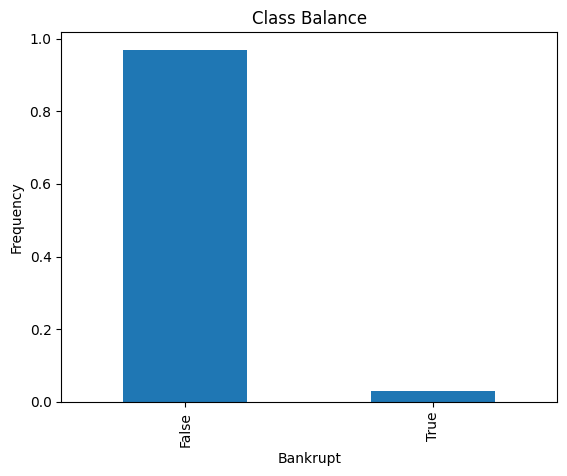

In [124]:
# Plot class balance
df["bankrupt"].value_counts(normalize = True)

fig, ax = plt.subplots()

df["bankrupt"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Bankrupt")
plt.ylabel("Frequency")
plt.title("Class Balance");

In [125]:
#split the dataset
target = "bankrupt"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


In [127]:
#standardizing for logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.97


In [129]:
model = make_pipeline(
    SimpleImputer(),
    LogisticRegression(class_weight='balanced', max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [130]:

importances = model.named_steps["logisticregression"].coef_[0]

In [131]:
odds_ratios = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratios.head()

,0
feat_19,0.097111
feat_91,0.228003
feat_16,0.290987
feat_46,0.303277
feat_86,0.348422


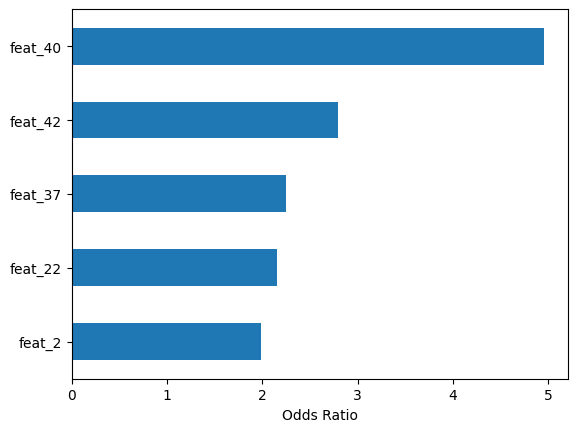

In [132]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind = "barh")
plt.xlabel("Odds Ratio");

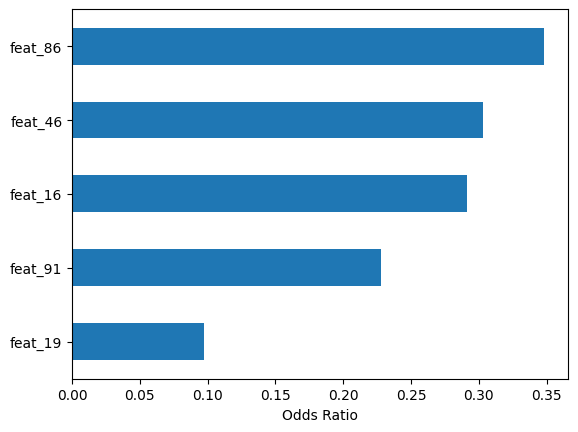

In [133]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind = "barh")
plt.xlabel("Odds Ratio");

In [134]:
# Get ROC metrics
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for True class





In [135]:
#roc_auc_score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.9451063153833934


In [136]:
#roc_curve (FPR, TPR, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
print("False Positive Rate (FPR):", fpr)
print("True Positive Rate (TPR):", tpr)
print("Thresholds:", thresholds)

False Positive Rate (FPR): [0.00000000e+00 8.39630563e-04 8.39630563e-04 1.67926113e-03
 1.67926113e-03 2.51889169e-03 2.51889169e-03 4.19815281e-03
 4.19815281e-03 5.03778338e-03 5.03778338e-03 6.71704450e-03
 6.71704450e-03 7.55667506e-03 7.55667506e-03 8.39630563e-03
 8.39630563e-03 1.17548279e-02 1.17548279e-02 1.34340890e-02
 1.34340890e-02 1.42737196e-02 1.42737196e-02 1.59529807e-02
 1.59529807e-02 1.76322418e-02 1.76322418e-02 2.09907641e-02
 2.09907641e-02 2.35096558e-02 2.35096558e-02 2.68681780e-02
 2.68681780e-02 4.03022670e-02 4.03022670e-02 4.19815281e-02
 4.19815281e-02 4.95382032e-02 4.95382032e-02 6.71704450e-02
 6.71704450e-02 6.96893367e-02 6.96893367e-02 7.13685978e-02
 7.13685978e-02 1.26784215e-01 1.26784215e-01 2.33417296e-01
 2.33417296e-01 9.95801847e-01 9.95801847e-01 1.00000000e+00]
True Positive Rate (TPR): [0.         0.         0.08108108 0.08108108 0.10810811 0.10810811
 0.18918919 0.18918919 0.21621622 0.21621622 0.27027027 0.27027027
 0.2972973  0.29729

In [137]:
# auc (from roc_curve)
roc_auc_manual = auc(fpr, tpr)
print("AUC (from roc_curve):", roc_auc_manual)


AUC (from roc_curve): 0.9451063153833934


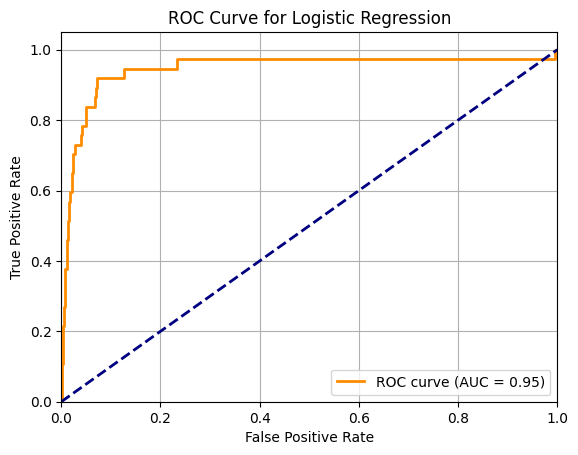

In [138]:

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

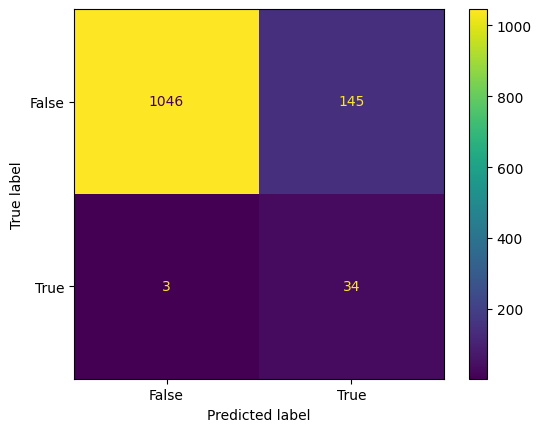

In [139]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [140]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      0.88      0.93      1191
        True       0.19      0.92      0.31        37

    accuracy                           0.88      1228
   macro avg       0.59      0.90      0.62      1228
weighted avg       0.97      0.88      0.92      1228

